In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
import warnings
warnings.filterwarnings("ignore")
import pickle
import os   

In [5]:
# Load the CSV files into DataFrames  from 1900 to 7-2024
data1 = pd.read_csv('dataset/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv')
data2 = pd.read_csv('dataset/ResaleFlatPricesBasedonApprovalDate19901999.csv')
data3 = pd.read_csv('dataset/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv')
data4 = pd.read_csv('dataset/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
data5 = pd.read_csv('dataset/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv')
# Concatenate the DataFrames
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

data.tail(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
933413,2014-12,YISHUN,5 ROOM,205,YISHUN ST 21,01 TO 03,134.0,Model A,1985,510000.0,NaN
933414,2014-12,YISHUN,5 ROOM,612,YISHUN ST 61,04 TO 06,121.0,Improved,1987,445000.0,NaN
933415,2014-12,YISHUN,5 ROOM,713,YISHUN ST 71,01 TO 03,122.0,Improved,1987,415000.0,NaN
933416,2014-12,YISHUN,5 ROOM,757,YISHUN ST 72,01 TO 03,122.0,Improved,1986,485000.0,NaN
933417,2014-12,YISHUN,5 ROOM,819,YISHUN ST 81,01 TO 03,127.0,Improved,1987,500000.0,NaN
933418,2014-12,YISHUN,5 ROOM,816,YISHUN ST 81,10 TO 12,122.0,Improved,1988,580000.0,NaN
933419,2014-12,YISHUN,EXECUTIVE,325,YISHUN CTRL,10 TO 12,146.0,Maisonette,1988,540000.0,NaN
933420,2014-12,YISHUN,EXECUTIVE,618,YISHUN RING RD,07 TO 09,164.0,Apartment,1992,738000.0,NaN
933421,2014-12,YISHUN,EXECUTIVE,277,YISHUN ST 22,07 TO 09,152.0,Maisonette,1985,592000.0,NaN
933422,2014-12,YISHUN,EXECUTIVE,277,YISHUN ST 22,04 TO 06,146.0,Maisonette,1985,545000.0,NaN


In [6]:
print(data.shape)
print(data.info())

(933423, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933423 entries, 0 to 933422
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                933423 non-null  object 
 1   town                 933423 non-null  object 
 2   flat_type            933423 non-null  object 
 3   block                933423 non-null  object 
 4   street_name          933423 non-null  object 
 5   storey_range         933423 non-null  object 
 6   floor_area_sqm       933423 non-null  float64
 7   flat_model           933423 non-null  object 
 8   lease_commence_date  933423 non-null  int64  
 9   resale_price         933423 non-null  float64
 10  remaining_lease      224373 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 78.3+ MB
None


In [7]:
data.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

## Pre-Processing

1. converting month feature to year and month

2. To Fill the remaining lease value All the lease commence are 100 years
to fill the null value **lease_commence_date + 99 - current year**

3. converted the df upper case format

4. storey_range is like **4 TO 6** this feature converted to median storage range like **5**

5. Encoding 'town', 'flat_model', Flat_type, Address:

       EG:
       
       Town       :  Bedok    : 1  , Bishan         : 2
       Flat model :  Improved : 5.0, New Generation : 2.0
       Flat type  :  1 Room   : 0.0, 3 Room         :2.0

In [8]:
town_encoder = LabelEncoder()
flat_model_encoder = OrdinalEncoder()
flat_type_encoder = OrdinalEncoder()
address_encoder = LabelEncoder()

def to_upper(df):
    string_cols = df.select_dtypes(include='object').columns
    df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
    return df

data = (data
        .pipe(to_upper)
        .assign(
            month=pd.to_datetime(data["month"], format="%Y-%m"),
            year=lambda x: x["month"].dt.year,
            months=lambda x: x["month"].dt.month,
            flat_type=lambda x: x['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION'),
            address=lambda x: x["block"] + " " + x["street_name"],
            town_ENCODED=lambda x: town_encoder.fit_transform(x["town"]),
            flat_model_ENCODED=lambda x: flat_model_encoder.fit_transform(x[["flat_model"]]).flatten(),
            flat_type_ENCODED=lambda x: flat_type_encoder.fit_transform(x[["flat_type"]]).flatten(),
            address_ENCODED=lambda x: address_encoder.fit_transform(x["address"]),
            price_per_sqm=lambda x: x['resale_price'] / x['floor_area_sqm']
        )
        .assign(median_storey_range=lambda x: x['storey_range']
                .apply(lambda storey_range: (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2).astype(int))
        .drop_duplicates()
)

In [9]:
# Dump the encoders and scaler to files
with open('town_encoder.pkl', 'wb') as f:
    pickle.dump(town_encoder, f)

with open('flat_model_encoder.pkl', 'wb') as f:
    pickle.dump(flat_model_encoder, f)

with open('flat_type_encoder.pkl', 'wb') as f:
    pickle.dump(flat_type_encoder, f)

with open('address_encoder.pkl', 'wb') as f:
    pickle.dump(address_encoder, f)

In [10]:
encoded_towns = town_encoder.classes_        #label encoding so classes_
print('town encoded as :')
for category, code in zip(encoded_towns, range(len(encoded_towns))):
    print(f"{category} is encoded as {code}")
print("=="*20)

encoded_flat_models = flat_model_encoder.categories_      #Ordinal encoding so categories_
print('flat_model encoded as :')
for category, code in zip(encoded_flat_models[0], range(len(encoded_flat_models[0]))):
    print(f"{category} is encoded as {code}")
print("=="*20)
print('flat_types encoded as :')
encoded_flat_types = flat_type_encoder.categories_
for category, code in zip(encoded_flat_types[0], range(len(encoded_flat_types[0]))):
    print(f"{category} is encoded as {code}")
print("=="*20)
# encoded_address = address_encoder.classes_        #label encoding so classes_
# for category, code in zip(encoded_address, range(len(encoded_address))):
#     print(f"{category} is encoded as {code}")

town encoded as :
ANG MO KIO is encoded as 0
BEDOK is encoded as 1
BISHAN is encoded as 2
BUKIT BATOK is encoded as 3
BUKIT MERAH is encoded as 4
BUKIT PANJANG is encoded as 5
BUKIT TIMAH is encoded as 6
CENTRAL AREA is encoded as 7
CHOA CHU KANG is encoded as 8
CLEMENTI is encoded as 9
GEYLANG is encoded as 10
HOUGANG is encoded as 11
JURONG EAST is encoded as 12
JURONG WEST is encoded as 13
KALLANG/WHAMPOA is encoded as 14
LIM CHU KANG is encoded as 15
MARINE PARADE is encoded as 16
PASIR RIS is encoded as 17
PUNGGOL is encoded as 18
QUEENSTOWN is encoded as 19
SEMBAWANG is encoded as 20
SENGKANG is encoded as 21
SERANGOON is encoded as 22
TAMPINES is encoded as 23
TOA PAYOH is encoded as 24
WOODLANDS is encoded as 25
YISHUN is encoded as 26
flat_model encoded as :
2-ROOM is encoded as 0
3GEN is encoded as 1
ADJOINED FLAT is encoded as 2
APARTMENT is encoded as 3
DBSS is encoded as 4
IMPROVED is encoded as 5
IMPROVED-MAISONETTE is encoded as 6
MAISONETTE is encoded as 7
MODEL A is en

In [11]:
#Cleaned data to perform EDA

cleaned_data = data[['year', 'town', 'flat_model', 'flat_type', 'storey_range', 'floor_area_sqm','price_per_sqm','lease_commence_date', 'address', 'resale_price']]

cleaned_data.to_csv('cleaned_data.csv',index=False)

model_data = data[['year', 'town_ENCODED', 'flat_model_ENCODED', 'flat_type_ENCODED', 'median_storey_range', 'floor_area_sqm','price_per_sqm','lease_commence_date', 'address_ENCODED', 'resale_price']]

model_data.to_csv('model_data.csv',index=False)

In [12]:
cleaned_data.head(5)

,year,town,flat_model,flat_type,storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address,resale_price
0,2000,ANG MO KIO,IMPROVED,3 ROOM,07 TO 09,69.0,2130.434783,1986,170 ANG MO KIO AVE 4,147000.0
1,2000,ANG MO KIO,IMPROVED,3 ROOM,04 TO 06,61.0,2360.655738,1986,174 ANG MO KIO AVE 4,144000.0
2,2000,ANG MO KIO,NEW GENERATION,3 ROOM,07 TO 09,73.0,2178.082192,1976,216 ANG MO KIO AVE 1,159000.0
3,2000,ANG MO KIO,NEW GENERATION,3 ROOM,07 TO 09,73.0,2287.671233,1976,215 ANG MO KIO AVE 1,167000.0
4,2000,ANG MO KIO,NEW GENERATION,3 ROOM,07 TO 09,67.0,2432.835821,1976,218 ANG MO KIO AVE 1,163000.0


In [13]:
model_data.head(5)

,year,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,median_storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address_ENCODED,resale_price
0,2000,0,5.0,2.0,8,69.0,2130.434783,1986,1641,147000.0
1,2000,0,5.0,2.0,5,61.0,2360.655738,1986,1696,144000.0
2,2000,0,12.0,2.0,8,73.0,2178.082192,1976,2375,159000.0
3,2000,0,12.0,2.0,8,73.0,2287.671233,1976,2359,167000.0
4,2000,0,12.0,2.0,8,67.0,2432.835821,1976,2417,163000.0


# EDA  

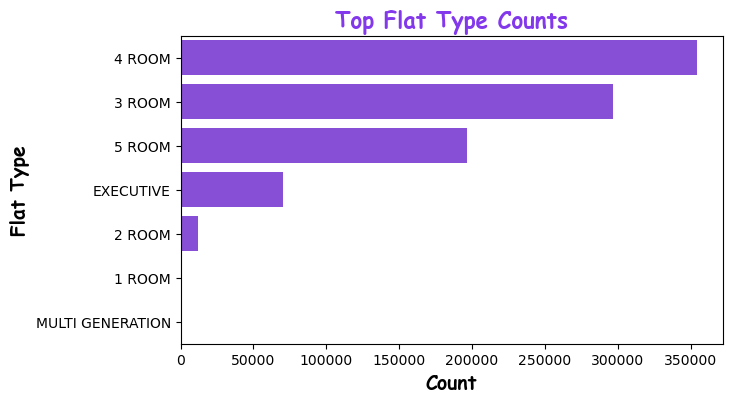

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 4))

sns.countplot(data=cleaned_data,
              y='flat_type',
              order=cleaned_data['flat_type'].value_counts().index,
              color='#8338ec', ax=ax)

ax.set_title('Top Flat Type Counts', fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()


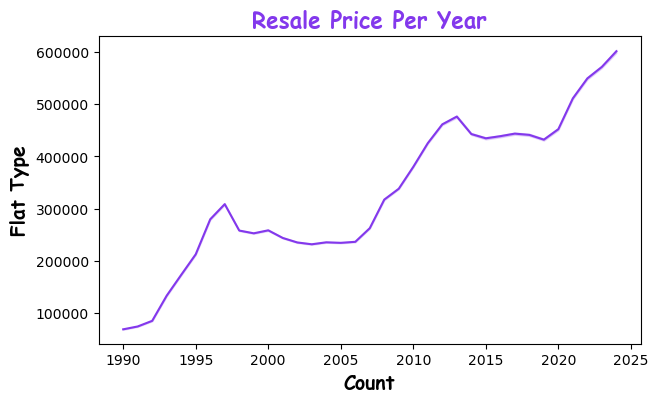

In [15]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 4))

sns.lineplot(data = model_data, x ='year', y = 'resale_price',color='#8338ec')

ax.set_title("Resale Price Per Year", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()

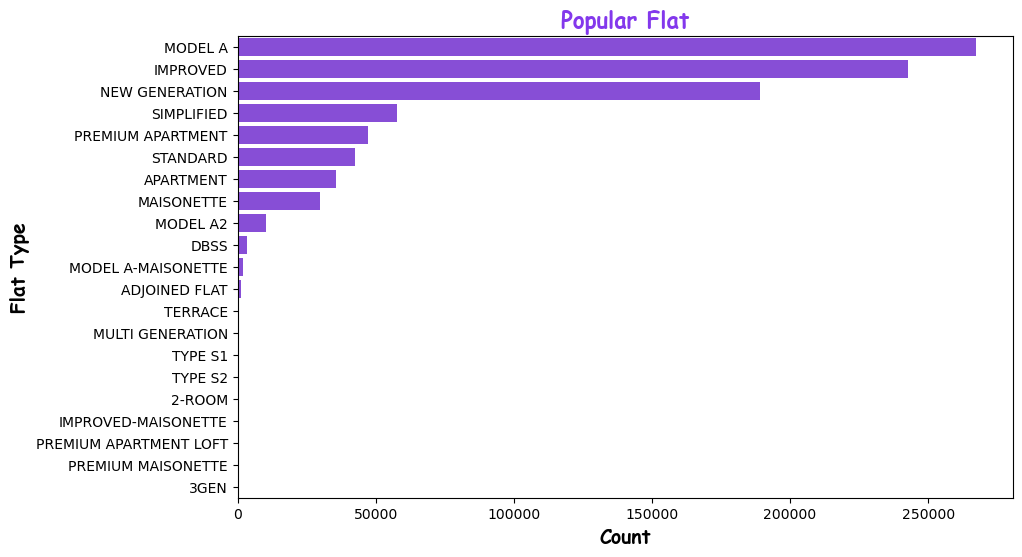

In [16]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

sns.countplot(data = cleaned_data,
              y = 'flat_model',
              order=cleaned_data['flat_model'].value_counts().index,color='#8338ec')

ax.set_title("Popular Flat", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')
plt.show()

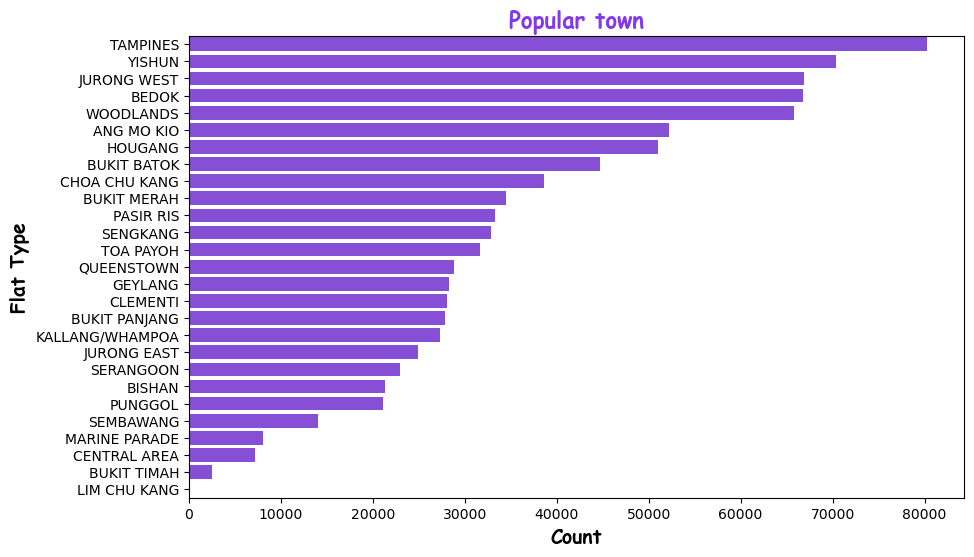

In [17]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

sns.countplot(data = cleaned_data,
              y = 'town',
              order=cleaned_data['town'].value_counts().index,color='#8338ec')

ax.set_title("Popular town", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.set_xlabel('Count', fontsize=14, fontweight='bold', fontname='Comic Sans MS')
ax.set_ylabel('Flat Type', fontsize=14, fontweight='bold', fontname='Comic Sans MS')

ax.tick_params(axis='both', colors='Black')

# Checking Skewness and Outlayer

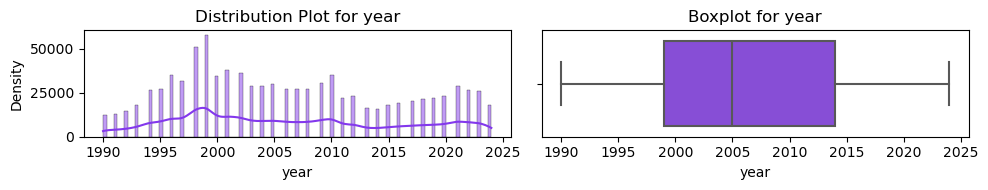

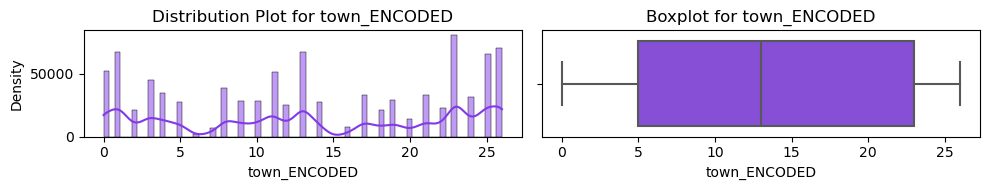

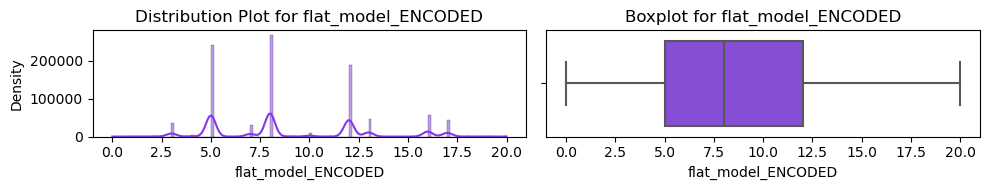

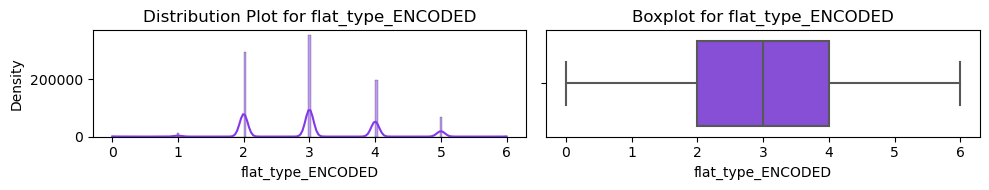

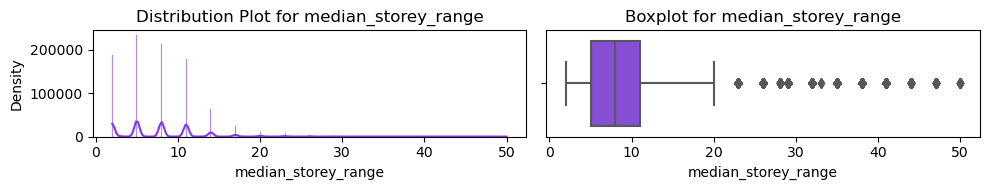

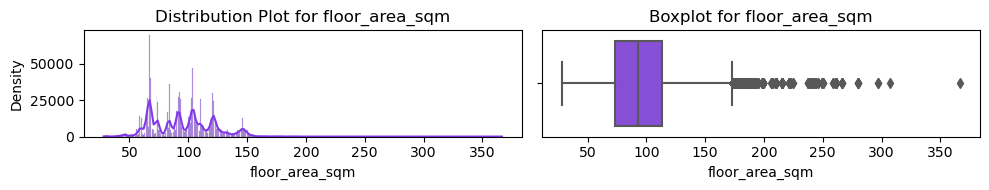

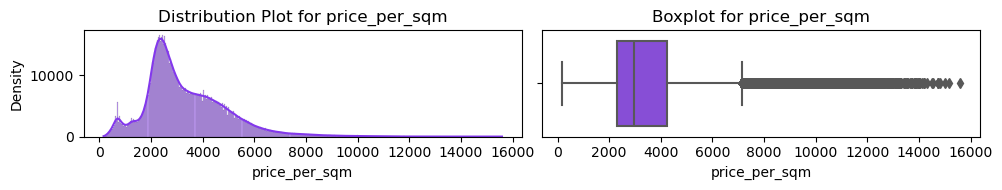

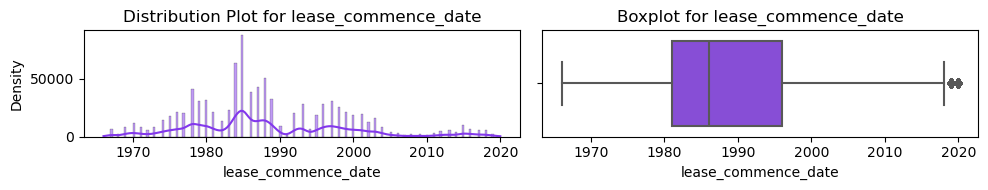

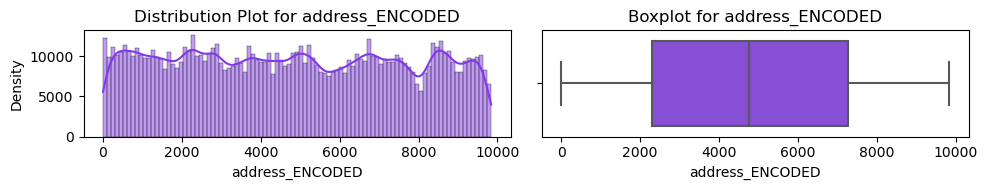

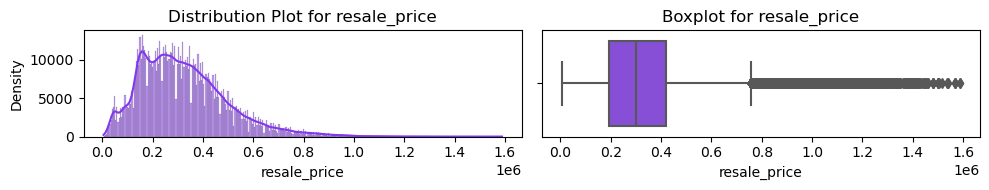

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df, column):
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))

    # Plotting the distribution plot
    sns.histplot(df[column], ax=axes[0], kde=True, color='#8338ec')
    axes[0].set_title("Distribution Plot for " + column)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Density')

    # Plotting the boxplot
    sns.boxplot(x=df[column], ax=axes[1], color='#8338ec')
    axes[1].set_title("Boxplot for " + column)
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

for col in model_data.columns:
    plot(model_data, col)

# Outlayer feature are:

In [19]:
#Outlier features
outlier_columns = ['median_storey_range', 'floor_area_sqm','price_per_sqm','lease_commence_date','resale_price']

# Calculate summary statistics before removing outliers
before_stats = model_data[outlier_columns].describe().T
print("Summary statistics before removing outliers:")
before_stats

Summary statistics before removing outliers:


,count,mean,std,min,25%,50%,75%,max
median_storey_range,931524.0,7.696842,4.830582,2.000000,5.000,8.000000,11.0,5.000000e+01
floor_area_sqm,931524.0,95.710311,25.812515,28.000000,73.000,93.000000,113.0,3.667000e+02
price_per_sqm,931524.0,3339.616112,1553.702760,161.290323,2296.875,2970.149254,4230.0,1.559140e+04
lease_commence_date,931524.0,1988.346827,10.727904,1966.000000,1981.000,1986.000000,1996.0,2.020000e+03
resale_price,931524.0,322867.035059,172289.887096,5000.000000,195000.000,300000.000000,420000.0,1.588000e+06


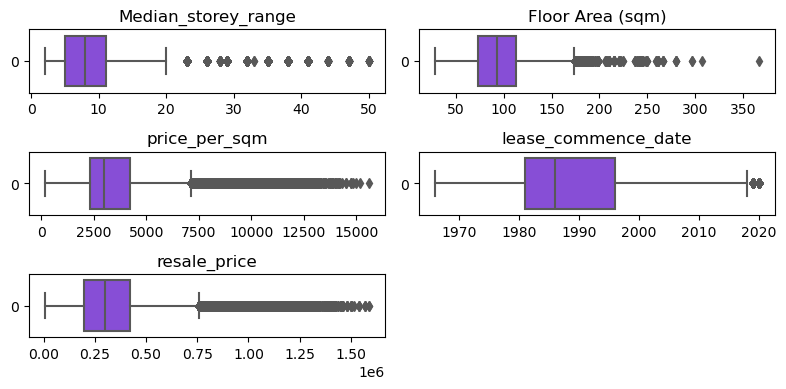

In [20]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(8, 4)

# Create boxplots
sns.boxplot(model_data['median_storey_range'], orient='h', ax=axes[0][0],color='#8338ec')
sns.boxplot(model_data['floor_area_sqm'], orient='h', ax=axes[0][1],color='#8338ec')
sns.boxplot(model_data['price_per_sqm'], orient='h', ax=axes[1][0],color='#8338ec')
sns.boxplot(model_data['lease_commence_date'], orient='h', ax=axes[1][1],color='#8338ec')
sns.boxplot(model_data['resale_price'], orient='h', ax=axes[2][0],color='#8338ec')

# Set titles for each subplot
axes[0][0].set_title('Median_storey_range')
axes[0][1].set_title('Floor Area (sqm)')
axes[1][0].set_title('price_per_sqm')
axes[1][1].set_title('lease_commence_date')
axes[2][0].set_title('resale_price')


fig.delaxes(axes[2][1])
plt.tight_layout()
plt.show()

In [21]:
for column in outlier_columns:
    Q1 = model_data[column].quantile(0.25)
    Q3 = model_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    model_data = model_data[(model_data[column] >= lower_bound) & (model_data[column] <= upper_bound)]

after_stats = model_data[outlier_columns].describe().T
print("Summary statistics after removing outliers:")
after_stats

Summary statistics after removing outliers:


,count,mean,std,min,25%,50%,75%,max
median_storey_range,875273.0,7.288363,4.118117,2.000000,5.000000,8.000000,11.000000,20.000000
floor_area_sqm,875273.0,94.955059,25.340346,28.000000,72.000000,93.000000,111.000000,173.000000
price_per_sqm,875273.0,3133.010834,1270.121622,161.290323,2264.150943,2873.239437,4008.474576,7034.883721
lease_commence_date,875273.0,1987.417819,9.758507,1966.000000,1980.000000,1986.000000,1995.000000,2016.000000
resale_price,875273.0,300273.549390,143616.053221,5000.000000,188000.000000,285000.000000,397000.000000,717000.000000


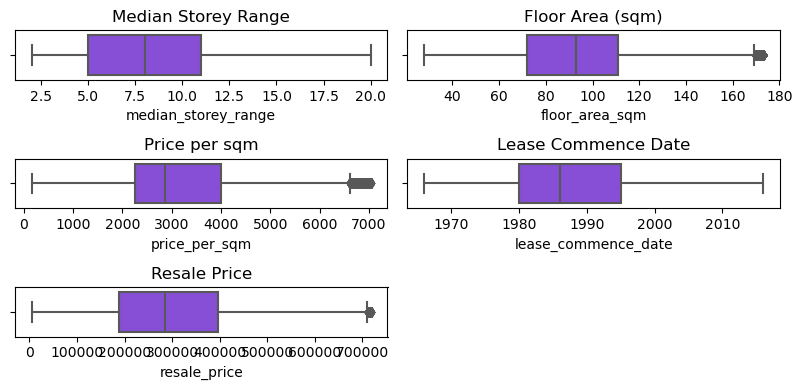

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(8, 4)

sns.boxplot(x=model_data['median_storey_range'], ax=axes[0, 0], color='#8338ec')
sns.boxplot(x=model_data['floor_area_sqm'], ax=axes[0, 1], color='#8338ec')
sns.boxplot(x=model_data['price_per_sqm'], ax=axes[1, 0], color='#8338ec')
sns.boxplot(x=model_data['lease_commence_date'], ax=axes[1, 1], color='#8338ec')
sns.boxplot(x=model_data['resale_price'], ax=axes[2, 0], color='#8338ec')

axes[0, 0].set_title('Median Storey Range')
axes[0, 1].set_title('Floor Area (sqm)')
axes[1, 0].set_title('Price per sqm')
axes[1, 1].set_title('Lease Commence Date')
axes[2, 0].set_title('Resale Price')

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

In [23]:
model_data.shape

(875273, 10)

# skewness check
   

In [24]:
model_data.skew()

year                   0.359292
town_ENCODED          -0.091703
flat_model_ENCODED     0.465909
flat_type_ENCODED      0.420892
median_storey_range    0.561533
floor_area_sqm         0.307469
price_per_sqm          0.435754
lease_commence_date    0.506964
address_ENCODED        0.043764
resale_price           0.419606
dtype: float64

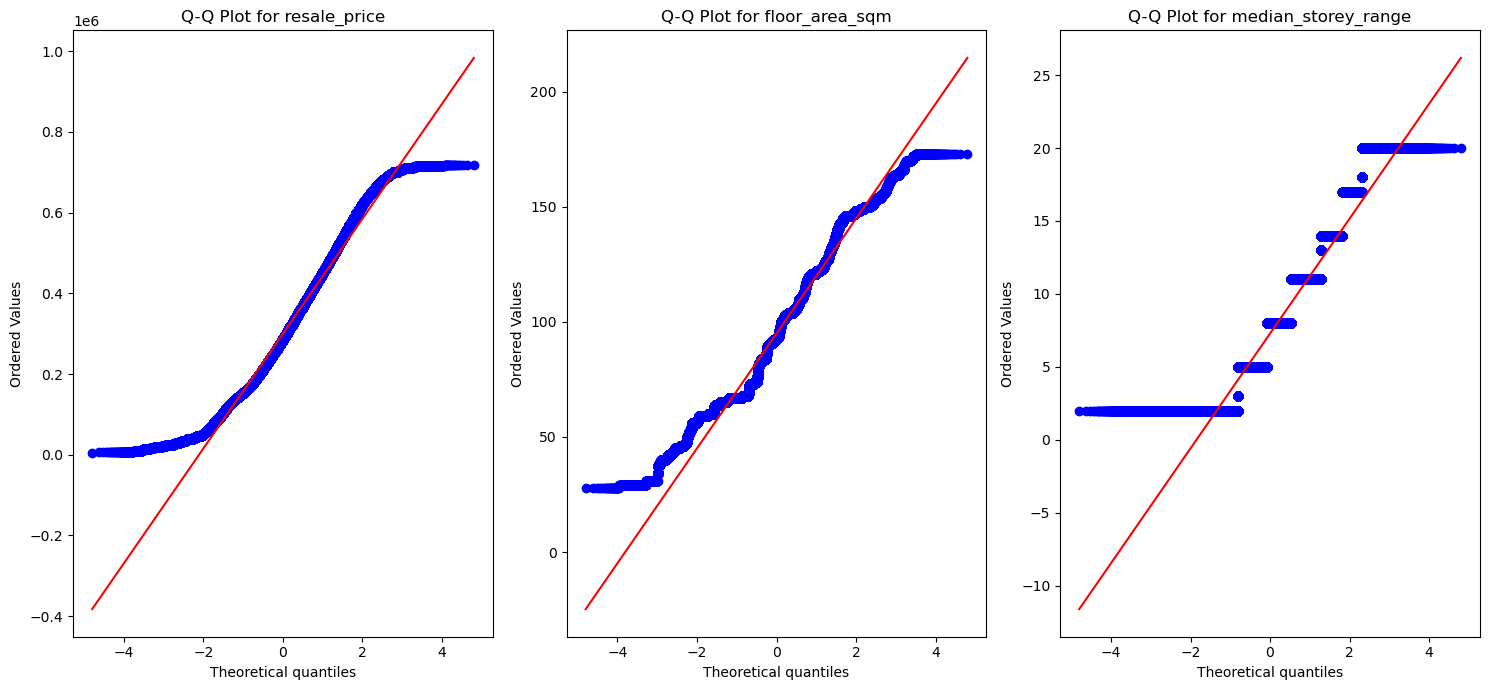

In [25]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import pylab


columns_to_plot = ['resale_price', 'floor_area_sqm','median_storey_range']  

plt.figure(figsize=(15, 7))

for i, col in enumerate(columns_to_plot):
    plt.subplot(1, len(columns_to_plot), i + 1)
    stat.probplot(model_data[col], dist='norm', plot=pylab)
    plt.title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()


In [26]:
model = model_data
model.head(2)

,year,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,median_storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address_ENCODED,resale_price
0,2000,0,5.0,2.0,8,69.0,2130.434783,1986,1641,147000.0
1,2000,0,5.0,2.0,5,61.0,2360.655738,1986,1696,144000.0


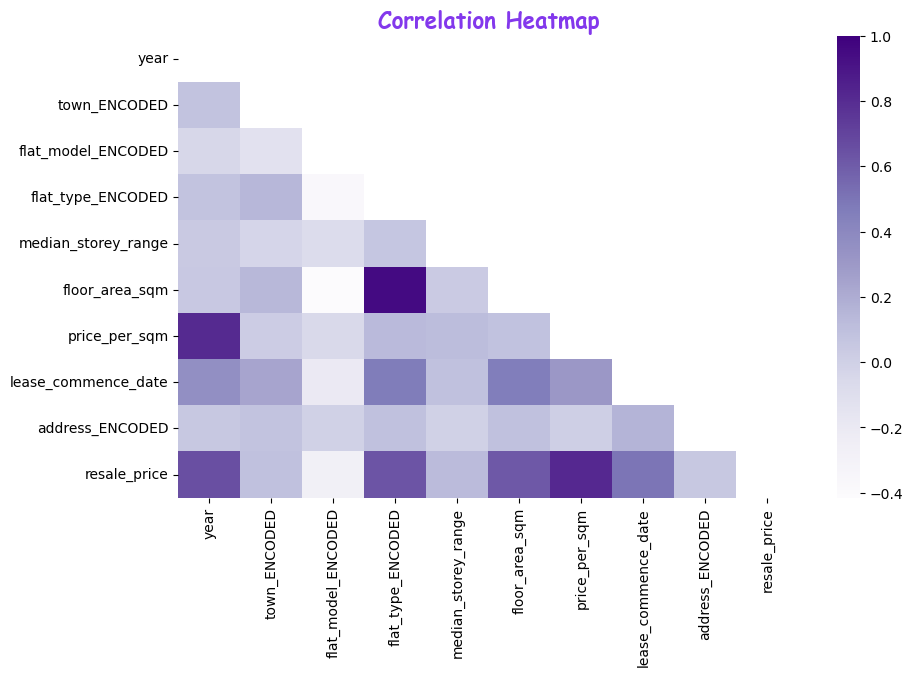

In [27]:
corr_matrix = model.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(corr_matrix, cmap="Purples", annot=True, mask=mask, ax=ax,vmax=1)

ax.set_title("Correlation Heatmap", fontsize=16, fontweight='bold', fontname='Comic Sans MS', color='#8338ec')
ax.tick_params(axis='both', colors='black')
plt.show()

In [28]:
model = model.sample(n=10000, random_state=42)

In [28]:
model.tail()

,year,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,median_storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address_ENCODED,resale_price
850177,2021,0,12.0,2.0,8,68.0,5000.000000,1981,6787,340000.0
622721,2010,13,8.0,3.0,11,104.0,3317.307692,1989,8537,345000.0
561881,2008,3,8.0,2.0,8,73.0,3109.589041,1985,2909,227000.0
850624,2021,5,10.0,3.0,8,90.0,4555.555556,1998,6361,410000.0
579762,2009,3,5.0,4.0,8,115.0,4060.869565,2005,4789,467000.0


# Model Building

In [29]:
#model import
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

In [30]:
X = model.drop(columns=["resale_price"])
y = model["resale_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [31]:
models = {
    "ExtraTreeRegressor": ExtraTreesRegressor(),
    'RandomForestRegressor()': RandomForestRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor()
}

n = X_test_scaled.shape[0]  # number of samples
p = X_test_scaled.shape[1]  # number of predictors

for model_name, model1 in models.items():
    model1.fit(X_train_scaled, y_train)
    
    y_train_pred = model1.predict(X_train_scaled)
    y_pred = model1.predict(X_test_scaled)
    
    
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_RMSE = np.sqrt(train_MSE)
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_R2 = r2_score(y_train, y_train_pred)
    train_Adjusted_R2 = 1 - ((1 - train_R2) * (n - 1) / (n - p - 1))
    
    test_MSE = mean_squared_error(y_test, y_pred)
    test_RMSE = np.sqrt(test_MSE)
    test_MAE = mean_absolute_error(y_test, y_pred)
    test_R2 = r2_score(y_test, y_pred)
    test_Adjusted_R2 = 1 - ((1 - test_R2) * (n - 1) / (n - p - 1))
    
    print("+-----------------------------------------------------------------------+")
    print(f"   -- {model_name} --              -- {model_name} --     ")
    print("+-----------------------------------+-----------------------------------+")
    print("| Model performance on training set |  Model performance on testing set | ")
    print("+-----------------------------------------------------------------------+")
    print(f"|         train_MAE : {train_MAE:.4f}        |           test_MAE : {test_MAE:.4f}    |  ")
    print(f"|        train_RMSE : {train_RMSE:.4f}        |          test_RMSE : {test_RMSE:.4f}    |")
    print(f"|         train_MSE : {train_MSE:.4f}        |           test_MSE : {test_MSE:.4f}|")
    print(f"|         train_R2  : {train_R2:.4f}        |           test_R2  : {test_R2:.4f}       | ")
    print(f"| train_Adjusted R2 : {train_Adjusted_R2:.4f}        |   test_Adjusted R2 : {test_Adjusted_R2:.4f}       | ")


+-----------------------------------------------------------------------+
   -- ExtraTreeRegressor --              -- ExtraTreeRegressor --     
+-----------------------------------+-----------------------------------+
| Model performance on training set |  Model performance on testing set | 
+-----------------------------------------------------------------------+
|         train_MAE : 0.0514        |           test_MAE : 1686.6167    |  
|        train_RMSE : 1.8048        |          test_RMSE : 3685.1013    |
|         train_MSE : 3.2571        |           test_MSE : 13579971.6412|
|         train_R2  : 1.0000        |           test_R2  : 0.9993       | 
| train_Adjusted R2 : 1.0000        |   test_Adjusted R2 : 0.9993       | 
+-----------------------------------------------------------------------+
   -- RandomForestRegressor() --              -- RandomForestRegressor() --     
+-----------------------------------+-----------------------------------+
| Model performance on traini

#Hyper Parameter tuning

In [32]:
from sklearn.model_selection import GridSearchCV

ET_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10,None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt',None],
    'criterion': ['squared_error', 'absolute_error']}


gridcv_models = [("ET", ExtraTreesRegressor(), ET_param_grid)]
gridcv_models

[('ET',
  ExtraTreesRegressor(),
  {'n_estimators': [100, 300],
   'max_depth': [10, None],
   'min_samples_split': [2, 5],
   'min_samples_leaf': [1, 2],
   'max_features': ['sqrt', None],
   'criterion': ['squared_error', 'absolute_error']})]

In [33]:
# model_param = {}
# for name, model, params in gridcv_models:
#     grid_search  = GridSearchCV(estimator=model,
#                                param_grid=params,
#                                cv=3,
#                                verbose=2,
#                                n_jobs=-1
#                               )
#     grid_search.fit(X_train, y_train)
#     model_param[name] = grid_search.best_params_
    
# for model_name in model_param:
#     print(f"===========Best Params for {model_name}===========")
#     print(model_param[model_name])

In [34]:
# Fitting 3 folds for each of 64 candidates, totalling 192 fits
# ===========Best Params for ET===========
# {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [33]:
models = {
    'ExtraTreeRegression' : ExtraTreesRegressor(
                                criterion='squared_error',
                                max_depth=None,
                                max_features=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                n_estimators=300)
}

n = X_test_scaled.shape[0]  # number of samples
p = X_test_scaled.shape[1]  # number of predictors

for model_name, final_model in models.items():
    final_model.fit(X_train_scaled, y_train)
    
    y_train_pred = final_model.predict(X_train_scaled)
    y_pred = final_model.predict(X_test_scaled)
    
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_RMSE = np.sqrt(train_MSE)
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_R2 = r2_score(y_train, y_train_pred)
    train_Adjusted_R2 = 1 - ((1 - train_R2) * (n - 1) / (n - p - 1))
    
    test_MSE = mean_squared_error(y_test, y_pred)
    test_RMSE = np.sqrt(test_MSE)
    test_MAE = mean_absolute_error(y_test, y_pred)
    test_R2 = r2_score(y_test, y_pred)
    test_Adjusted_R2 = 1 - ((1 - test_R2) * (n - 1) / (n - p - 1))
    
    print("+-----------------------------------------------------------------------+")
    print(f"   -- {model_name} --              -- {model_name} --     ")
    print("+-----------------------------------+-----------------------------------+")
    print("| Model performance on training set |  Model performance on testing set | ")
    print("+-----------------------------------------------------------------------+")
    print(f"|         train_MAE : {train_MAE:.4f}        |           test_MAE : {test_MAE:.4f}    |  ")
    print(f"|        train_RMSE : {train_RMSE:.4f}        |          test_RMSE : {test_RMSE:.4f}    |")
    print(f"|         train_MSE : {train_MSE:.4f}        |           test_MSE : {test_MSE:.4f}|")
    print(f"|         train_R2  : {train_R2:.4f}        |           test_R2  : {test_R2:.4f}       | ")
    print(f"| train_Adjusted R2 : {train_Adjusted_R2:.4f}        |   test_Adjusted R2 : {test_Adjusted_R2:.4f}       | ")


+-----------------------------------------------------------------------+
   -- ExtraTreeRegression --              -- ExtraTreeRegression --     
+-----------------------------------+-----------------------------------+
| Model performance on training set |  Model performance on testing set | 
+-----------------------------------------------------------------------+
|         train_MAE : 0.0529        |           test_MAE : 1581.8263    |  
|        train_RMSE : 1.2684        |          test_RMSE : 3667.6997    |
|         train_MSE : 1.6087        |           test_MSE : 13452021.3239|
|         train_R2  : 1.0000        |           test_R2  : 0.9993       | 
| train_Adjusted R2 : 1.0000        |   test_Adjusted R2 : 0.9993       | 


In [34]:
ET_model = ExtraTreesRegressor(
                                criterion='squared_error',
                                max_depth=None,
                                max_features=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                n_estimators=300)

ET_regression_model = ET_model.fit(X_train_scaled, y_train)

with open('ET_regression_model.pkl', 'wb') as file:
    pickle.dump(ET_regression_model, file)

In [35]:
import pandas as pd
import pickle

with open('town_encoder.pkl', 'rb') as f:
    town_encoder = pickle.load(f)
with open('flat_model_encoder.pkl', 'rb') as f:
    flat_model_encoder = pickle.load(f)
with open('flat_type_encoder.pkl', 'rb') as f:
    flat_type_encoder = pickle.load(f)
with open('address_encoder.pkl', 'rb') as f:
    address_encoder = pickle.load(f)

def data_transformation_for_the_model(df):
    
    def to_upper(df):
        string_cols = df.select_dtypes(include='object').columns
        df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
        return df
    
    df = (df
          .pipe(to_upper)
          .assign(
                  town_ENCODED=lambda x: town_encoder.transform(x[["town"]]),
                  flat_model_ENCODED=lambda x: flat_model_encoder.transform(x[["flat_model"]]),
                  flat_type_ENCODED=lambda x: flat_type_encoder.transform(x[["flat_type"]]),
                  address_ENCODED=lambda x: address_encoder.transform(x[["address"]]),
                  median_storey_range=lambda x: x['storey_range'].apply(lambda storey_range: (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2).astype(int))
          [['year', 'town_ENCODED', 'flat_model_ENCODED', 'flat_type_ENCODED', 'median_storey_range',
            'floor_area_sqm', 'price_per_sqm', 'lease_commence_date', 'address_ENCODED']]
          )
    return df

new_data = {
    'year': [2024, 2024, 2024, 2024, 2024],
    'town': ['YISHUN', 'YISHUN', 'YISHUN', 'YISHUN', 'YISHUN'],
    'flat_model': ['SIMPLIFIED', 'IMPROVED', 'IMPROVED', 'IMPROVED', 'MAISONETTE'],
    'flat_type': ['4 ROOM', '5 ROOM', '5 ROOM', '5 ROOM', 'EXECUTIVE'],
    'storey_range': ['10 TO 12', '10 TO 12', '10 TO 12', '10 TO 12', '10 TO 12'],
    'floor_area_sqm': [84.0, 132.0, 113.0, 112.0, 146.0],
    'price_per_sqm': [5952.380952, 5287.878788, 6106.194690, 5803.571429, 5273.972603],
    'lease_commence_date': [1987, 1986, 2018, 2018, 1985],
    'address': ['719 YISHUN ST 71', '776 YISHUN AVE 2', '508B YISHUN AVE 4', '674B YISHUN AVE 4', '277 YISHUN ST 22'],
}

new_df = pd.DataFrame(new_data)
ready_to_predict = data_transformation_for_the_model(new_df)
ready_to_predict


,year,town_ENCODED,flat_model_ENCODED,flat_type_ENCODED,median_storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address_ENCODED
0,2024,26,16.0,3.0,11,84.0,5952.380952,1987,8480
1,2024,26,5.0,4.0,11,132.0,5287.878788,1986,8812
2,2024,26,5.0,4.0,11,113.0,6106.194690,2018,6356
3,2024,26,5.0,4.0,11,112.0,5803.571429,2018,8039
4,2024,26,7.0,5.0,11,146.0,5273.972603,1985,3380


In [36]:

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

scaled_features = scaler.transform(ready_to_predict)

with open('ET_regression_model.pkl', 'rb') as file:
    final_model = pickle.load(file)

predicted_price = final_model.predict(scaled_features) 
predicted_price

array([505287.36      , 680892.58666667, 692194.29333333, 646464.46666667,
       706242.96      ])

In [37]:
cleaned_data.tail()

,year,town,flat_model,flat_type,storey_range,floor_area_sqm,price_per_sqm,lease_commence_date,address,resale_price
933418,2014,YISHUN,IMPROVED,5 ROOM,10 TO 12,122.0,4754.098361,1988,816 YISHUN ST 81,580000.0
933419,2014,YISHUN,MAISONETTE,EXECUTIVE,10 TO 12,146.0,3698.630137,1988,325 YISHUN CTRL,540000.0
933420,2014,YISHUN,APARTMENT,EXECUTIVE,07 TO 09,164.0,4500.000000,1992,618 YISHUN RING RD,738000.0
933421,2014,YISHUN,MAISONETTE,EXECUTIVE,07 TO 09,152.0,3894.736842,1985,277 YISHUN ST 22,592000.0
933422,2014,YISHUN,MAISONETTE,EXECUTIVE,04 TO 06,146.0,3732.876712,1985,277 YISHUN ST 22,545000.0


In [ ]:
import pickle
import pandas as pd
import numpy as np
import streamlit as st
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import boxcox

st.set_page_config(page_title="Singapore Resale Flat Price Prediction - Made by: yabase", layout="wide", initial_sidebar_state="auto")        

with open('town_encoder.pkl', 'rb') as f:
    town_encoder = pickle.load(f)
with open('flat_model_encoder.pkl', 'rb') as f:
    flat_model_encoder = pickle.load(f)
with open('flat_type_encoder.pkl', 'rb') as f:
    flat_type_encoder = pickle.load(f)
with open('address_encoder.pkl', 'rb') as f:
    address_encoder = pickle.load(f)
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)


storey = ['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12', '11 TO 15', '13 TO 15', 
          '16 TO 18', '16 TO 20', '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30', 
          '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40', '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', 
          '49 TO 51']

all_addresses = address_encoder.classes_.tolist()
all_towns  = town_encoder.classes_.tolist()
all_flat_model = flat_model_encoder.categories_[0].tolist()
flat_type_mapping  = flat_type_encoder.categories_[0].tolist()

def get_user_input():
    
    st.subheader(":violet[Fill all the fields and press the button below to view the **Predicted price** of Resale Flat Price : ]")
    cc1, cc2 = st.columns([2, 2])
    
    with cc1:
        year = st.number_input("Year (YYYY) : ", min_value=1990, max_value=2034)
        town = st.selectbox("Town : ", all_towns)
        flat_model = st.selectbox("Flat Model : ", all_flat_model)
        flat_type = st.selectbox("Flat Type : ", list(flat_type_mapping))
        storey_range = st.selectbox("Storey Range : ", storey)    
    with cc2:  
        floor_area_sqm = st.number_input("Floor Area (sqm) : ")
        price_per_sqm = st.number_input("price Area (sqm) : ")
        lease_commence_date = st.number_input("Lease Commencement Year (YYYY) : ", min_value=1966, max_value=2023)
        address = st.selectbox('Enter the Address with Block Number with Street name :', all_addresses)


    user_input_data = {
        'year': year,
        'town': town,
        'flat_model': flat_model,
        'flat_type': flat_type,
        'storey_range': storey_range,
        'floor_area_sqm': floor_area_sqm,
        'price_per_sqm': price_per_sqm,
        'lease_commence_date': lease_commence_date,
        'address': address }
    
    return pd.DataFrame(user_input_data, index=[0])

def load_model():
    with open('ET_regression_model.pkl', 'rb') as file:
        final_model = pickle.load(file)
    return final_model

def data_transformation_for_the_model(df):
    
    def to_upper(df):
        string_cols = df.select_dtypes(include='object').columns
        df[string_cols] = df[string_cols].apply(lambda x: x.str.upper())
        return df
    
    df = (df
          .pipe(to_upper)
          .assign(
                  town_ENCODED=lambda x: town_encoder.transform(x[["town"]]),
                  flat_model_ENCODED=lambda x: flat_model_encoder.transform(x[["flat_model"]]),
                  flat_type_ENCODED=lambda x: flat_type_encoder.transform(x[["flat_type"]]),
                  address_ENCODED=lambda x: address_encoder.transform(x[["address"]]),
                  median_storey_range=lambda x: x['storey_range'].apply(lambda storey_range: (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2).astype(int))
          [['year', 'town_ENCODED', 'flat_model_ENCODED', 'flat_type_ENCODED', 'median_storey_range',
            'floor_area_sqm', 'price_per_sqm', 'lease_commence_date', 'address_ENCODED']]
          )


    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    
    return df

def main():
    
    with st.sidebar: 
        st.image("https://www.onepointltd.com/wp-content/uploads/2020/03/inno2.png")
        st.title("Select options")
        choice = st.radio("Navigation", ["Home","Model","Multiple prediction"])
        st.info("This project application helps you predict the price and status")
    
    if choice == "Home":
        st.title("Welcome to the Singapore Resale Flat Price Prediction App")
    
        st.subheader("About the App")
        st.write("- Welcome to our interactive application designed to predict resale flat prices in Singapore. Whether you're a prospective buyer, seller, or simply curious about property trends, our app provides accurate predictions based on advanced machine learning models.")
        
        st.subheader("Key Features")
        st.markdown("- **Predictive Power**: Utilizing state-of-the-art machine learning algorithms, our app forecasts resale flat prices with high precision, leveraging historical data and real-time trends.")
        st.markdown("- **User-Friendly Interface**: Designed for ease of use, our intuitive interface allows you to input key parameters and receive instant predictions, making informed decisions simpler than ever.")
        st.markdown("- **Customizable Inputs**: Tailor predictions by adjusting parameters such as floor area, lease commencement year, town, flat model, and more, ensuring personalized results.")
        st.markdown("- **Insightful Visualizations**: Explore trends and patterns in resale flat prices through interactive charts and graphs, providing deeper insights into the market dynamics.")
        
        st.subheader("How It Works")
        st.markdown("1. **Input Your Details**: Enter details such as floor area, lease commencement year, town, flat model, and other relevant parameters.")
        st.markdown("2. **Receive Predictions**: Our app processes your inputs through advanced machine learning models to generate accurate predictions of resale flat prices.")
        st.markdown("3. **Explore Insights**: Gain valuable insights into factors influencing resale flat prices and make informed decisions based on reliable forecasts.")
        
        st.subheader("Get Started")
        st.write("Ready to explore the future of resale flat prices in Singapore? Click on the sidebar to begin predicting or explore more about how our app can benefit you.")
        
        st.subheader("Why Choose Us?")
        st.markdown("- **Expertise**: Developed by seasoned data scientists specializing in real estate analytics, ensuring reliable predictions.")
        st.markdown("- **Accuracy**: Backed by rigorous model training and validation, our predictions are among the most accurate in the industry.")
        
        st.subheader("Testimonials")
        st.markdown('"Using the app helped me understand the market better and make smarter investment decisions." - Real Estate Investor')
        st.markdown('"Highly recommend for anyone looking to buy or sell property in Singapore!" - Homeowner')
        
        st.subheader('**created by** \n Yabase')

    if choice == "Model":
        st.title(":violet[Singapore Resale Flat Price Prediction]")
        user_input_data = get_user_input()

        if st.button("Predict"):
            df = data_transformation_for_the_model(user_input_data)
            model = load_model()
            predicted_price = model.predict(df)
            st.success(f':green: [$] :green: {predicted_price[0]:.2f}   with 100% Accuracy')
            
    if choice == "Multiple prediction":
        st.title(":violet[Multiple Resale Flat Price Prediction]")
        
        uploaded_file = st.file_uploader("Choose a CSV file", type="csv")
        
        if uploaded_file is not None:
            data = pd.read_csv(uploaded_file)
               
            st.write("Uploaded Data")
            st.write(data)
                   
            data_transformed = data_transformation_for_the_model(data)
            model = load_model()
            predictions = model.predict(data_transformed)
            predicted_prices = predictions  

            data['Predicted_Price_Range'] = predicted_prices

            st.write("Data with Predictions")
            st.write(data)

            csv = data.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="Download data with predictions as CSV",
                data=csv,
                file_name='predicted_resale_prices.csv',
                mime='text/csv',
            )
            
if __name__ == "__main__":
    main()
